# Inverse Problem in Imaging First Assignment

## A
In order to check for ill posed/ well posed, there are three conditions to be checked.  Namely, Existence, Uniqueness and stability.
If all three conditions are satisfied, the problem is well-posed, while if one or more of the conditions are violated, the problem is ill-posed.
Yet due to the fact that we add random noise, it is very unlikely that the solution is unique. As it can create multiple possible solutions. 

As an example:
In the code `K @ u + delta * np.random.randn(n)`, when we solve for u, even if we knew K and f, there will be infinite many possible solutions due to the noise

Hence, both are ill posed
### Imports

In [128]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


In [129]:
# parameters and grid
deltas = [0.001, 0.01, 0.1]
n = 100
a = 100
uni_delta = 1e-1
x = np.linspace(0,1,n)
# define forward operator
c = np.exp(-a*x**2)/((n-1)*np.sqrt(np.pi/a))
K = la.toeplitz(c)

U, s, Vt = np.linalg.svd(K)
S = np.zeros((n,n))
S[:n, :n] = np.diag(s)

#hevyside 1
u1 = abs(x - 0.5)<.2
#hevyside 2
u2 = x*(1-x)

#universal f with universal delta
f = K@u1 + uni_delta*np.random.randn(n)


## Heavyside 1

Condition number of K: 10261826102285957120.00


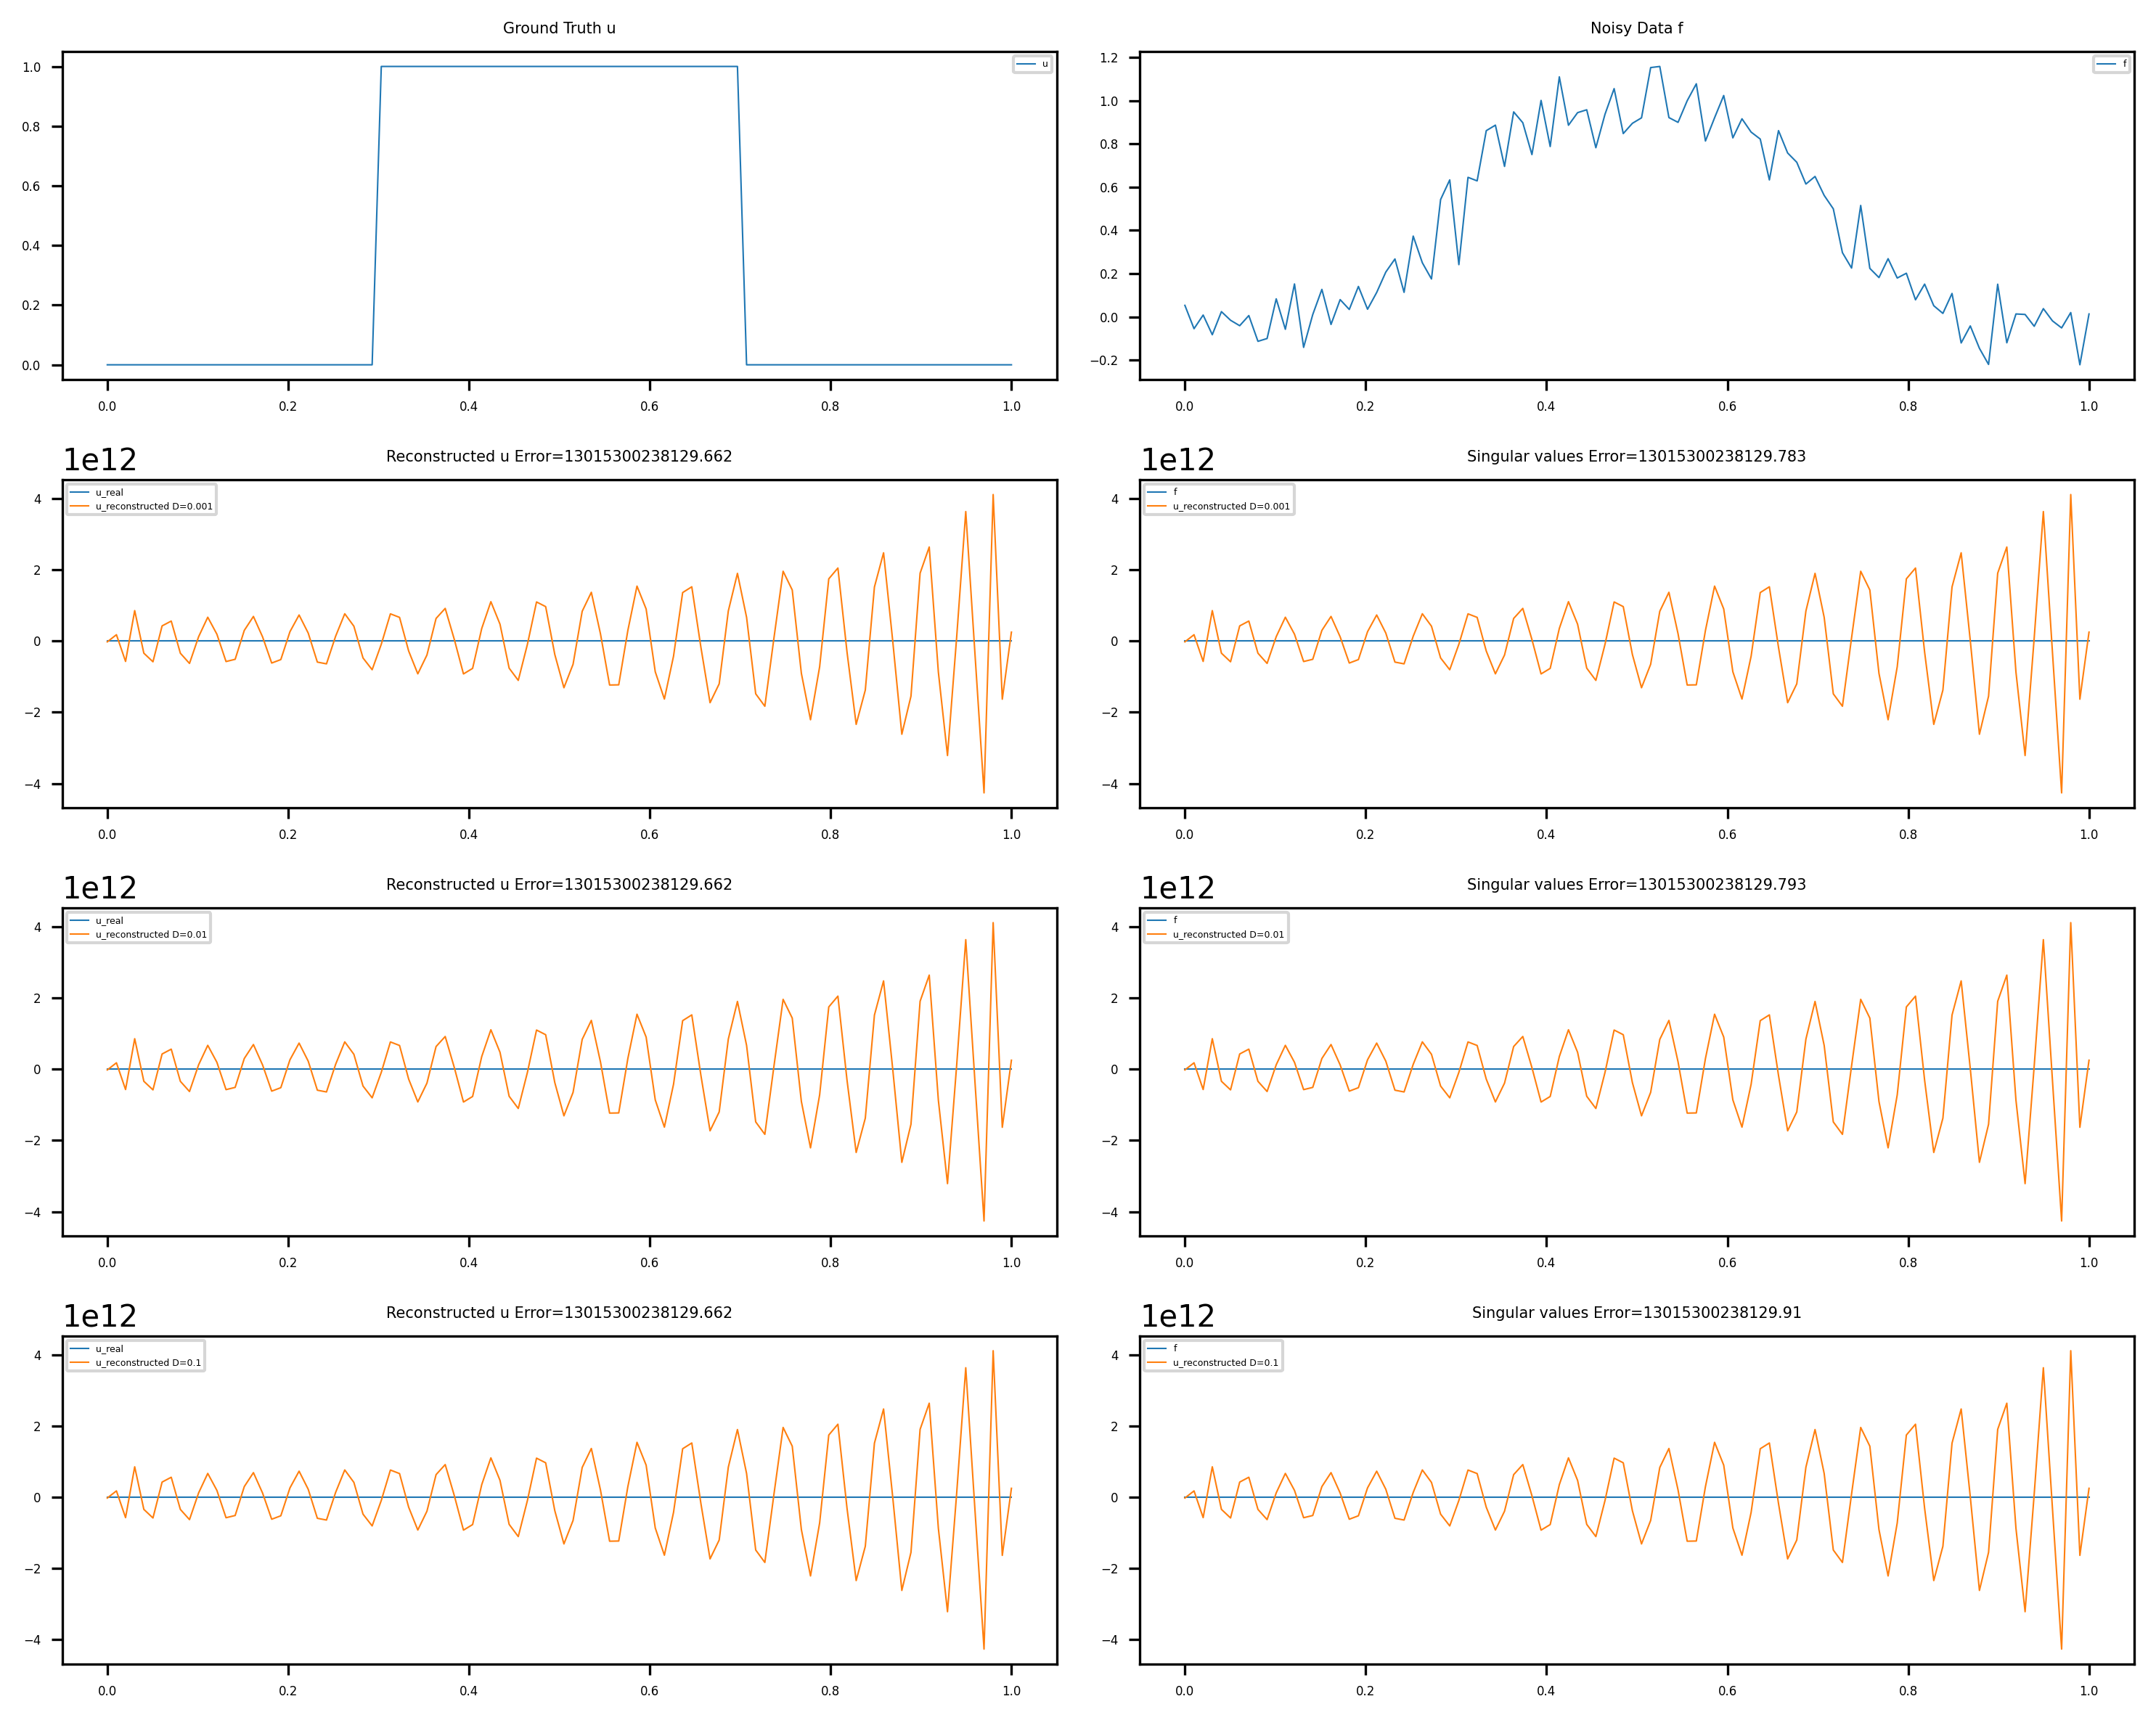

In [130]:

cond = np.linalg.cond(K)
print(f"Condition number of K: {cond:.2f}")

# plot base
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(10,8))

axes[0,0].plot(x,u1,label='u', linewidth=0.5)
axes[0,0].set_title('Ground Truth u', fontsize=5)
axes[0,0].legend(fontsize=3)
axes[0, 0].tick_params(labelsize=4)

axes[0,1].plot(x,f,label='f', linewidth=0.5)
axes[0,1].set_title('Noisy Data f', fontsize=5)
axes[0,1].legend(fontsize=3)
axes[0, 1].tick_params(labelsize=4)

# loop over different noise levels
for i, delta in enumerate(deltas):

    f_cur = K@u1 + delta*np.random.randn(n)

    K_inv_verify = np.linalg.pinv(K)

    u_reconstructed = K_inv_verify @ f

    Berror = round(np.linalg.norm(u1 - u_reconstructed, ord=2),3)
    ferror = round(np.linalg.norm(f_cur - u_reconstructed, ord=2),3)

    axes[i+1, 0].plot(x, u1, label='u_real', linewidth=0.5)
    axes[i+1, 0].plot(x, u_reconstructed, label=f'u_reconstructed D={delta}', linewidth=0.5)
    axes[i+1, 0].set_title(f'Reconstructed u Error={Berror}', fontsize=5)
    axes[i+1, 0].tick_params(labelsize=4)
    axes[i+1, 0].legend(fontsize=3)

    axes[i+1, 1].plot(x, f_cur, label='f', linewidth=0.5)
    axes[i+1, 1].plot(x, u_reconstructed, label=f'u_reconstructed D={delta}', linewidth=0.5)
    axes[i+1, 1].tick_params(labelsize=4)
    axes[i+1, 1].set_title(f'Singular values Error={ferror}', fontsize=5)
    axes[i+1, 1].legend(fontsize=3)

fig.tight_layout()
plt.show()


# Heavisite 2

Condition number of K: 10261826102285957120.00


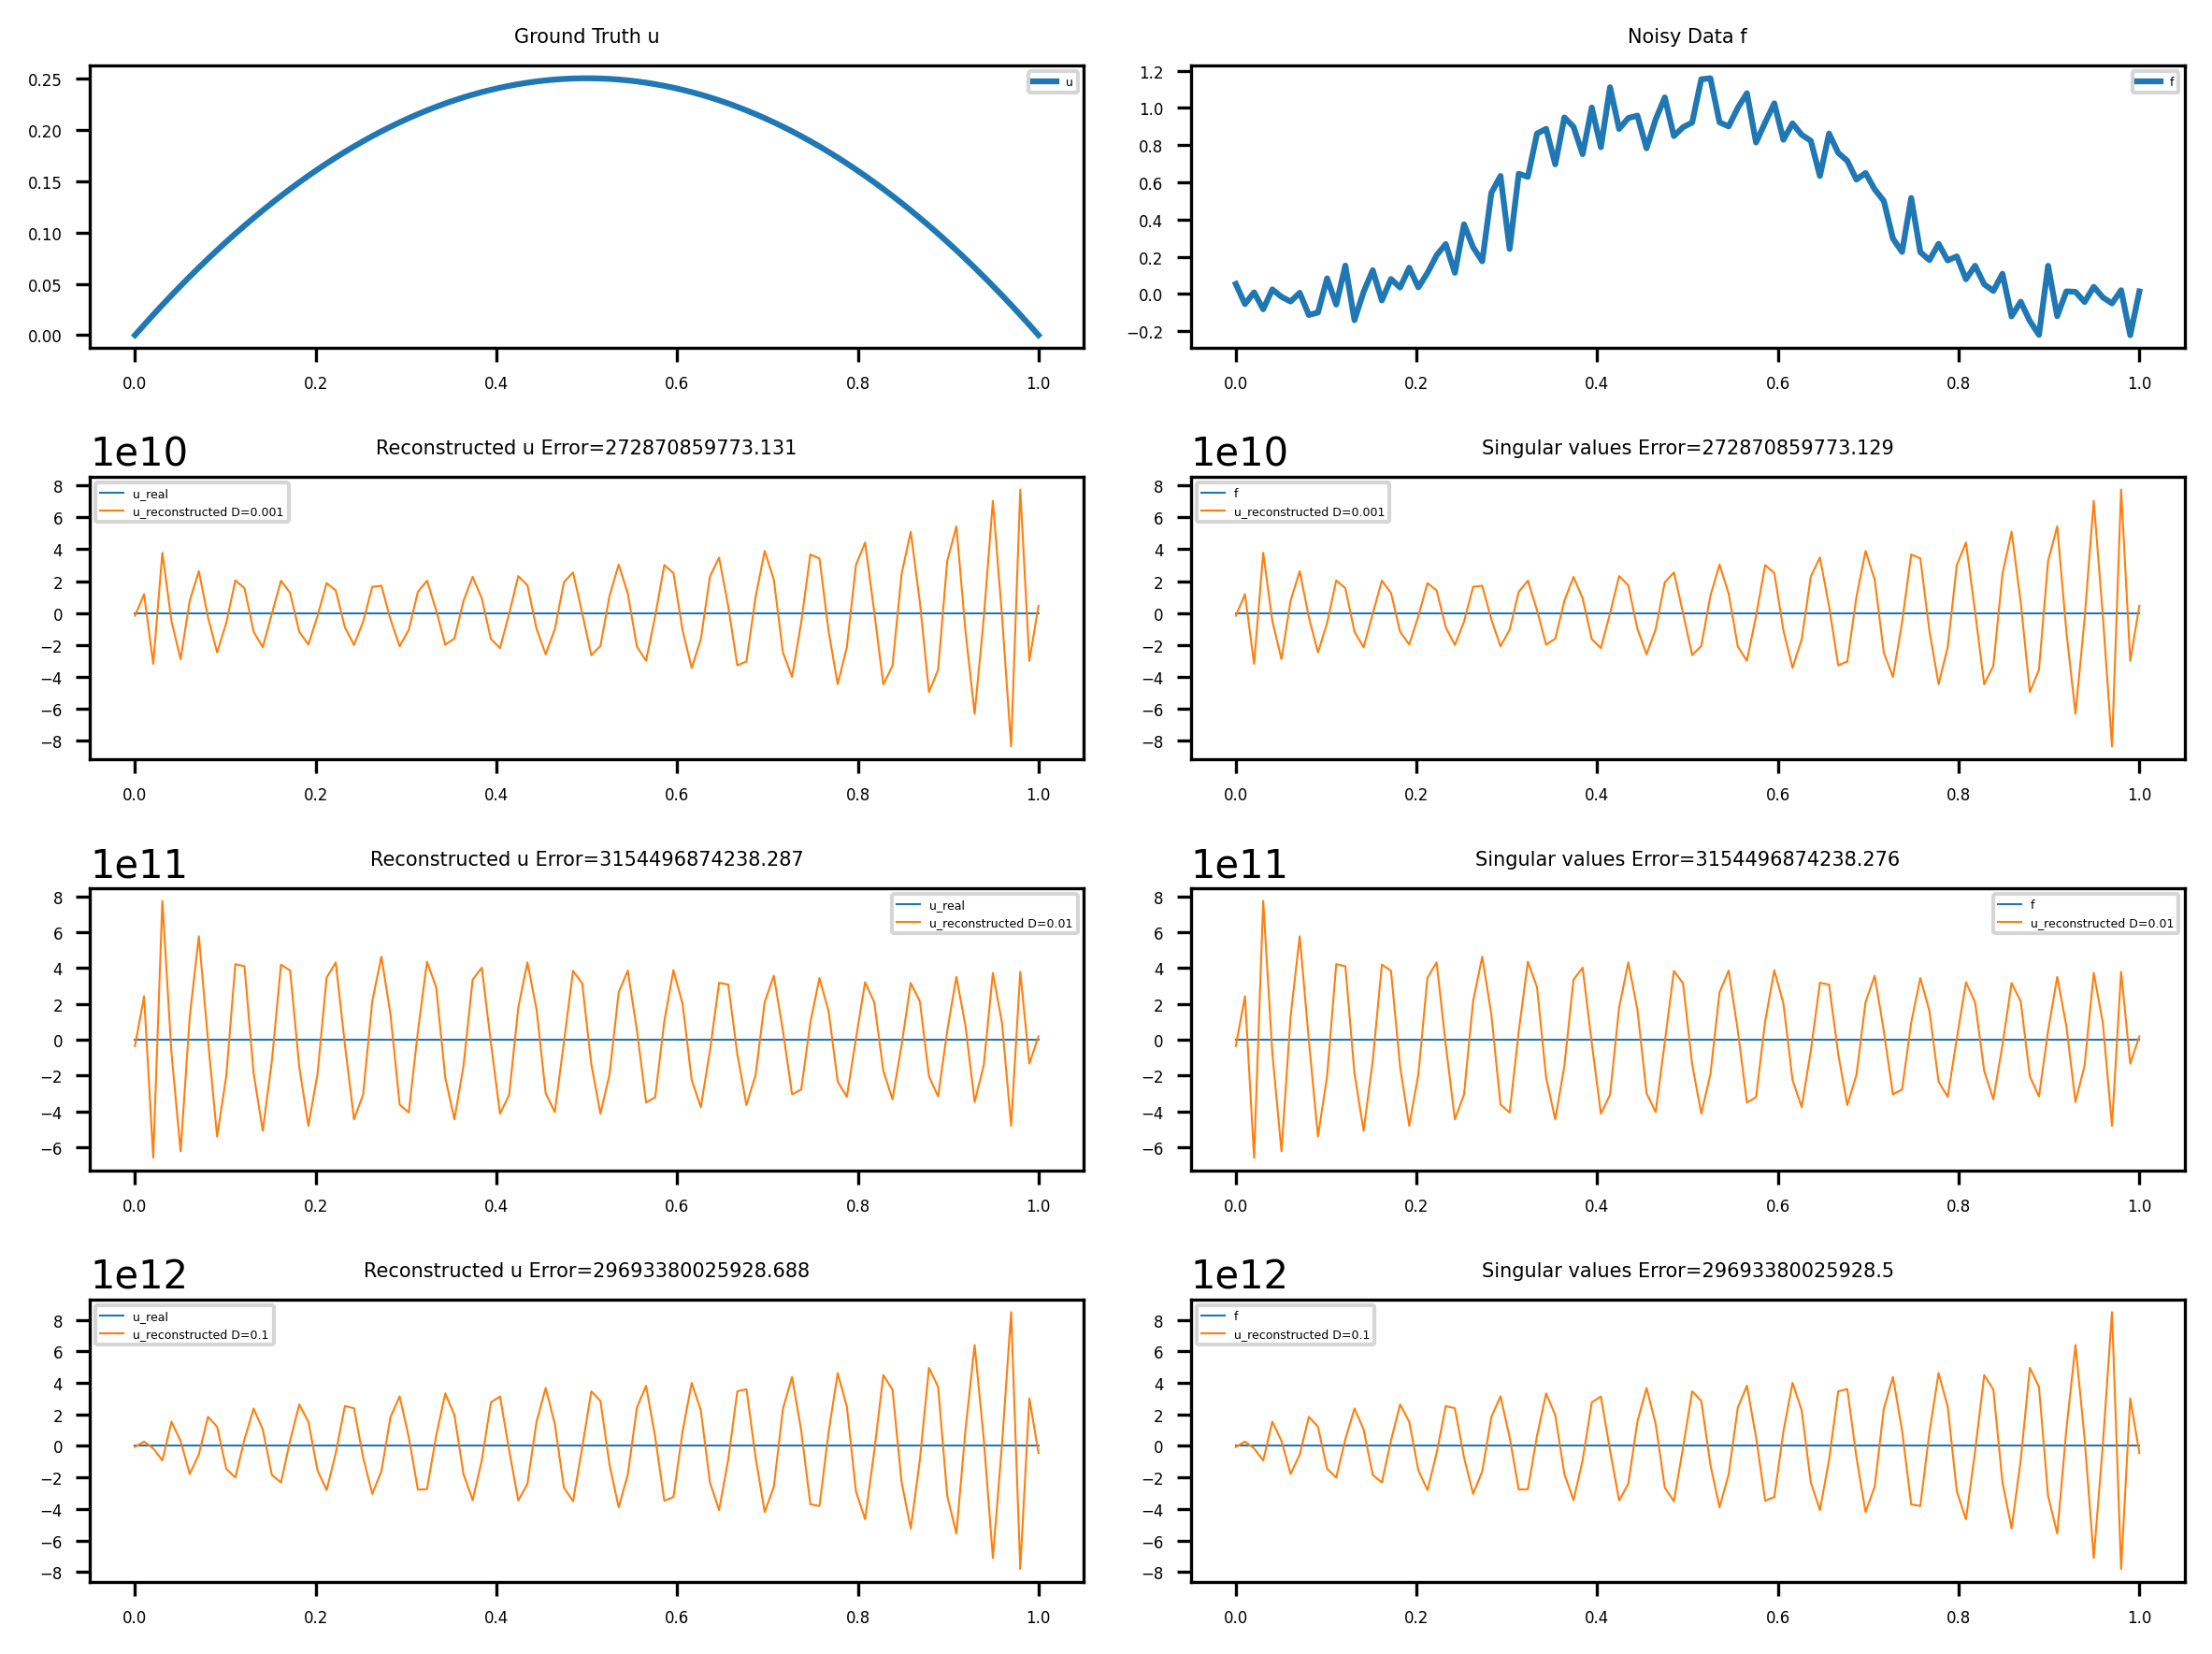

In [131]:
# cond = np.linalg.cond(K)
print(f"Condition number of K: {cond:.2f}")

# compute pseudo-inverse and reconstructed signal
U, s, Vt = np.linalg.svd(K)
# compute pseudo-inverse and reconstructed signal
K_inv = Vt.T @ np.linalg.pinv(np.diag(s)) @ U.T

# plot
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(8,6))

axes[0,0].plot(x,u2,label='u')
axes[0,0].set_title('Ground Truth u', fontsize=5)
axes[0,0].legend(fontsize=3)
axes[0, 0].tick_params(labelsize=4)

axes[0,1].plot(x,f,label='f')
axes[0,1].set_title('Noisy Data f', fontsize=5)
axes[0,1].legend(fontsize=3)
axes[0, 1].tick_params(labelsize=4)

# loop over different noise levels
for i, delta in enumerate(deltas):
    #forward Operator
    f_cur = K@u2 + delta*np.random.randn(n)

    # Reconstruct
    u_reconstructed = K_inv@f_cur
    
    Berror = round(np.linalg.norm(u2 - u_reconstructed, ord=2),3)
    ferror = round(np.linalg.norm(f_cur - u_reconstructed, ord=2),3)

    axes[i+1,0].plot(x, u2, label='u_real', linewidth=0.5)
    axes[i+1,0].plot(x, u_reconstructed, label='u_reconstructed D={}'.format(delta), linewidth=0.5)
    axes[i+1,0].set_title('Reconstructed u Error={}'.format(Berror), fontsize=5)
    axes[i+1,0].tick_params(labelsize=4)
    axes[i+1,0].legend(fontsize=3)

    # plot f and reconstructed u
    axes[i+1,1].plot(x, f_cur, label='f', linewidth=0.5)
    axes[i+1,1].plot(x, u_reconstructed, label='u_reconstructed D={}'.format(delta), linewidth=0.5)
    axes[i+1,1].tick_params(labelsize=4)
    axes[i+1,1].set_title('Singular values Error={}'.format(ferror), fontsize=5)
    axes[i+1,1].legend(fontsize=3)

fig.tight_layout()
plt.show()


### Reflection

We can see from the graph without truncation that the problem is ill-posed for both Heaviside functions. The instability of the inverse reconstruction demonstrates this. The problem's ill-posedness is also indicated by the high condition number of approximately 4.44 x 1018. Furthermore, it is also observable that in both heavysite functions , as the variance of the random noise increases, so do the forward and backward errors. This emphasizes the inverse problem's instability even more.

## Question C

For the trancation, I would compute K as follow. 
I calculate the tau based on the noise level  All the singular values larger then this tau, would be truncate to 0

### Observe Singular Values

<!-- As `n=100` , we know that we would have `100` singular values out of the `np.linalg.svd(K)` function. To better understand what the correct truncated `K_truncate` should be to solve the ill poseness issue, we would first plot the singular values. -->

As `n=100`, we know that we would have `100` singular values out of the `np.linalg.svd(K)` function. To better understand what the correct truncated `K_truncate` should be to solve the ill-posedness issue, we would first plot the singular values. 

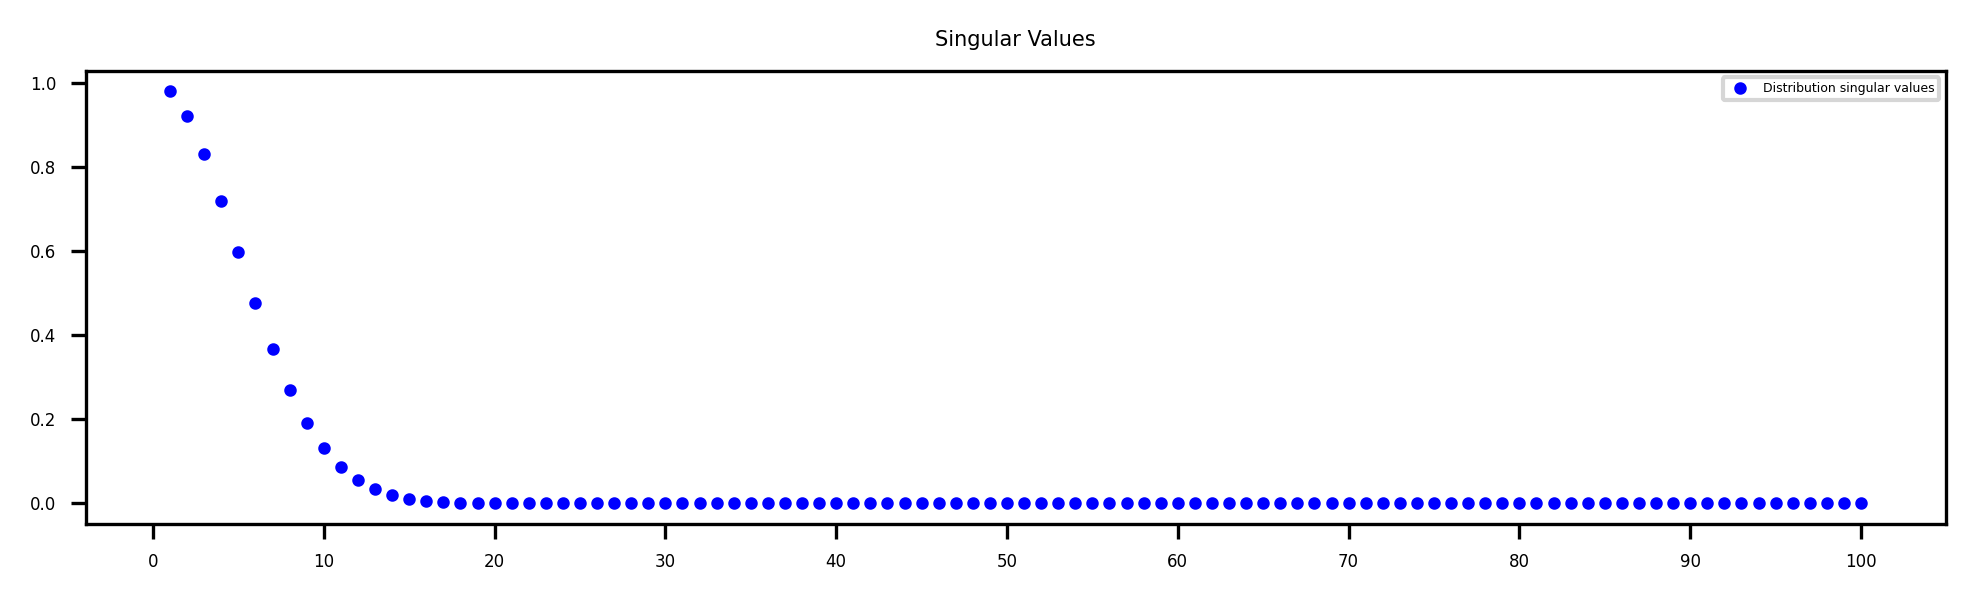

In [132]:
fig, ax = plt.subplots(figsize=(8,2))

ax.plot(np.arange(s.shape[0])+1,s, 'bo',markersize=2, label='Distribution singular values')
ax.set_title('Singular Values', fontsize=5)

plt.xticks(np.arange(0, n+1, 10) )
ax.tick_params(labelsize=4)
ax.legend(fontsize=3)

plt.show()


When performing a pseudoinverse, the presence of many singular values approaching zero, as shown in the graph, poses a problem. This is due to the fact that the inverse operation multiplies small singular values, resulting in large and unstable numbers. As a result, the singular values must be truncated in order to retain only the dominant ones and obtain a stable solution.

## Observe

Therefore, we would choose two different `T_truncate=5, T_truncate=13` and observe the results.

First of all, Lets observe the result of the trucation

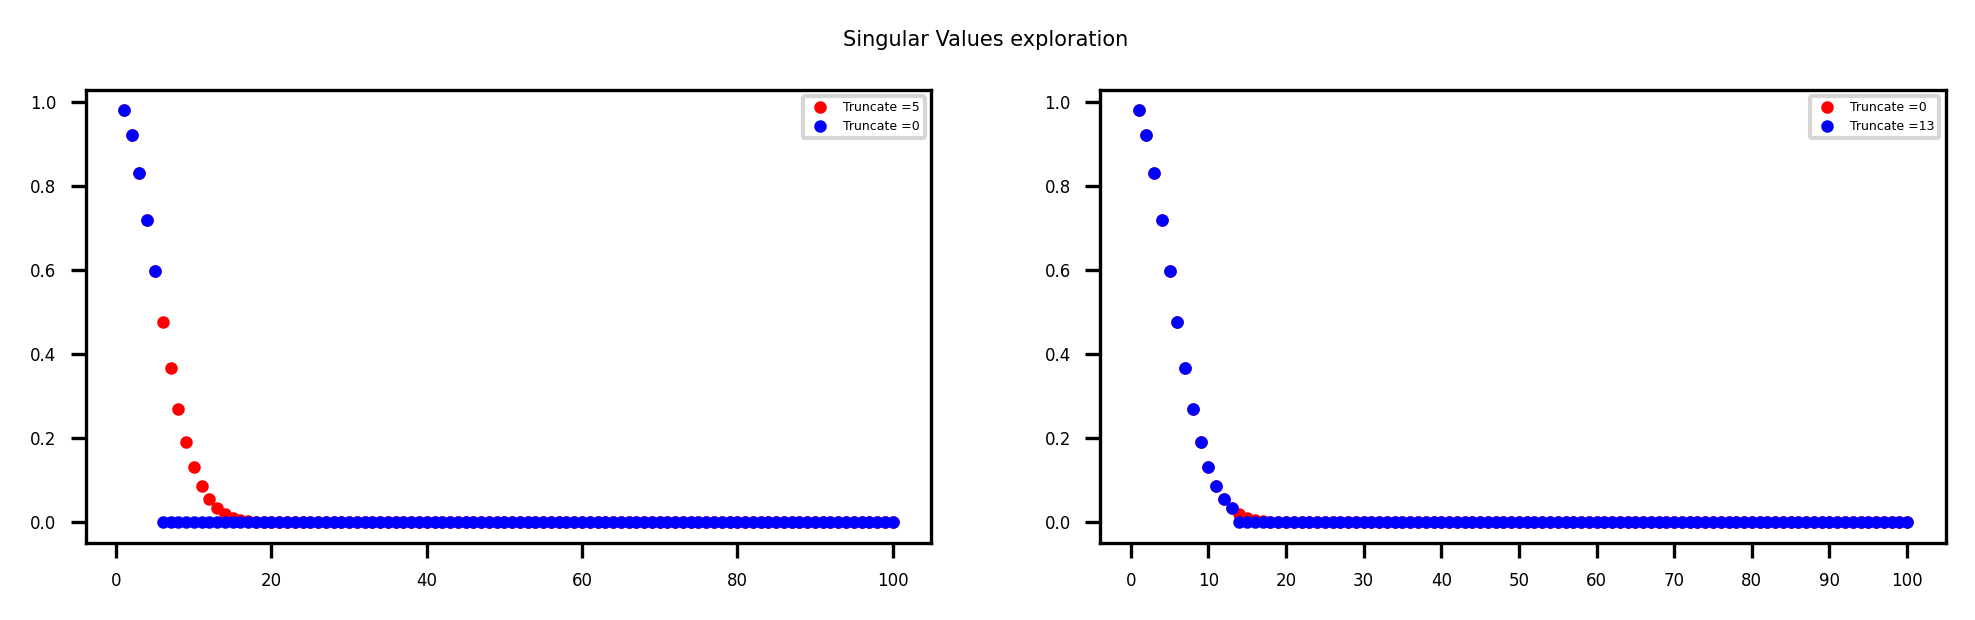

In [133]:
T_trun5 = 5
T_trun13 = 13

s_5 = np.zeros_like(s)
s_13 = np.zeros_like(s)

T_truncate_5 = s[:T_trun5]
T_truncate_13 = s[:T_trun13]

s_5[:T_trun5] =T_truncate_5
s_13[:T_trun13] =T_truncate_13

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,2))

ax[0].plot(np.arange(s_5.shape[0])+1,s, 'ro',markersize=2, label=f'Truncate ={T_trun5}')
ax[0].plot(np.arange(s.shape[0])+1,s_5, 'bo',markersize=2, label='Truncate =0')
ax[0].legend(fontsize=3)
ax[0].tick_params(labelsize=4)


ax[1].plot(np.arange(s.shape[0])+1,s, 'ro',markersize=2, label='Truncate =0')
ax[1].plot(np.arange(s_13.shape[0])+1,s_13, 'bo',markersize=2, label=f'Truncate ={T_trun13}')
ax[1].legend(fontsize=3)
ax[1].tick_params(labelsize=4)


plt.xticks(np.arange(0, n+1, 10) )
fig.suptitle('Singular Values exploration', fontsize=5) # set global title
plt.show()


## Implement on both (C)

For this analysis, we will only consider the scenario where `K_truncate=5` and examine both the forward and backward errors.

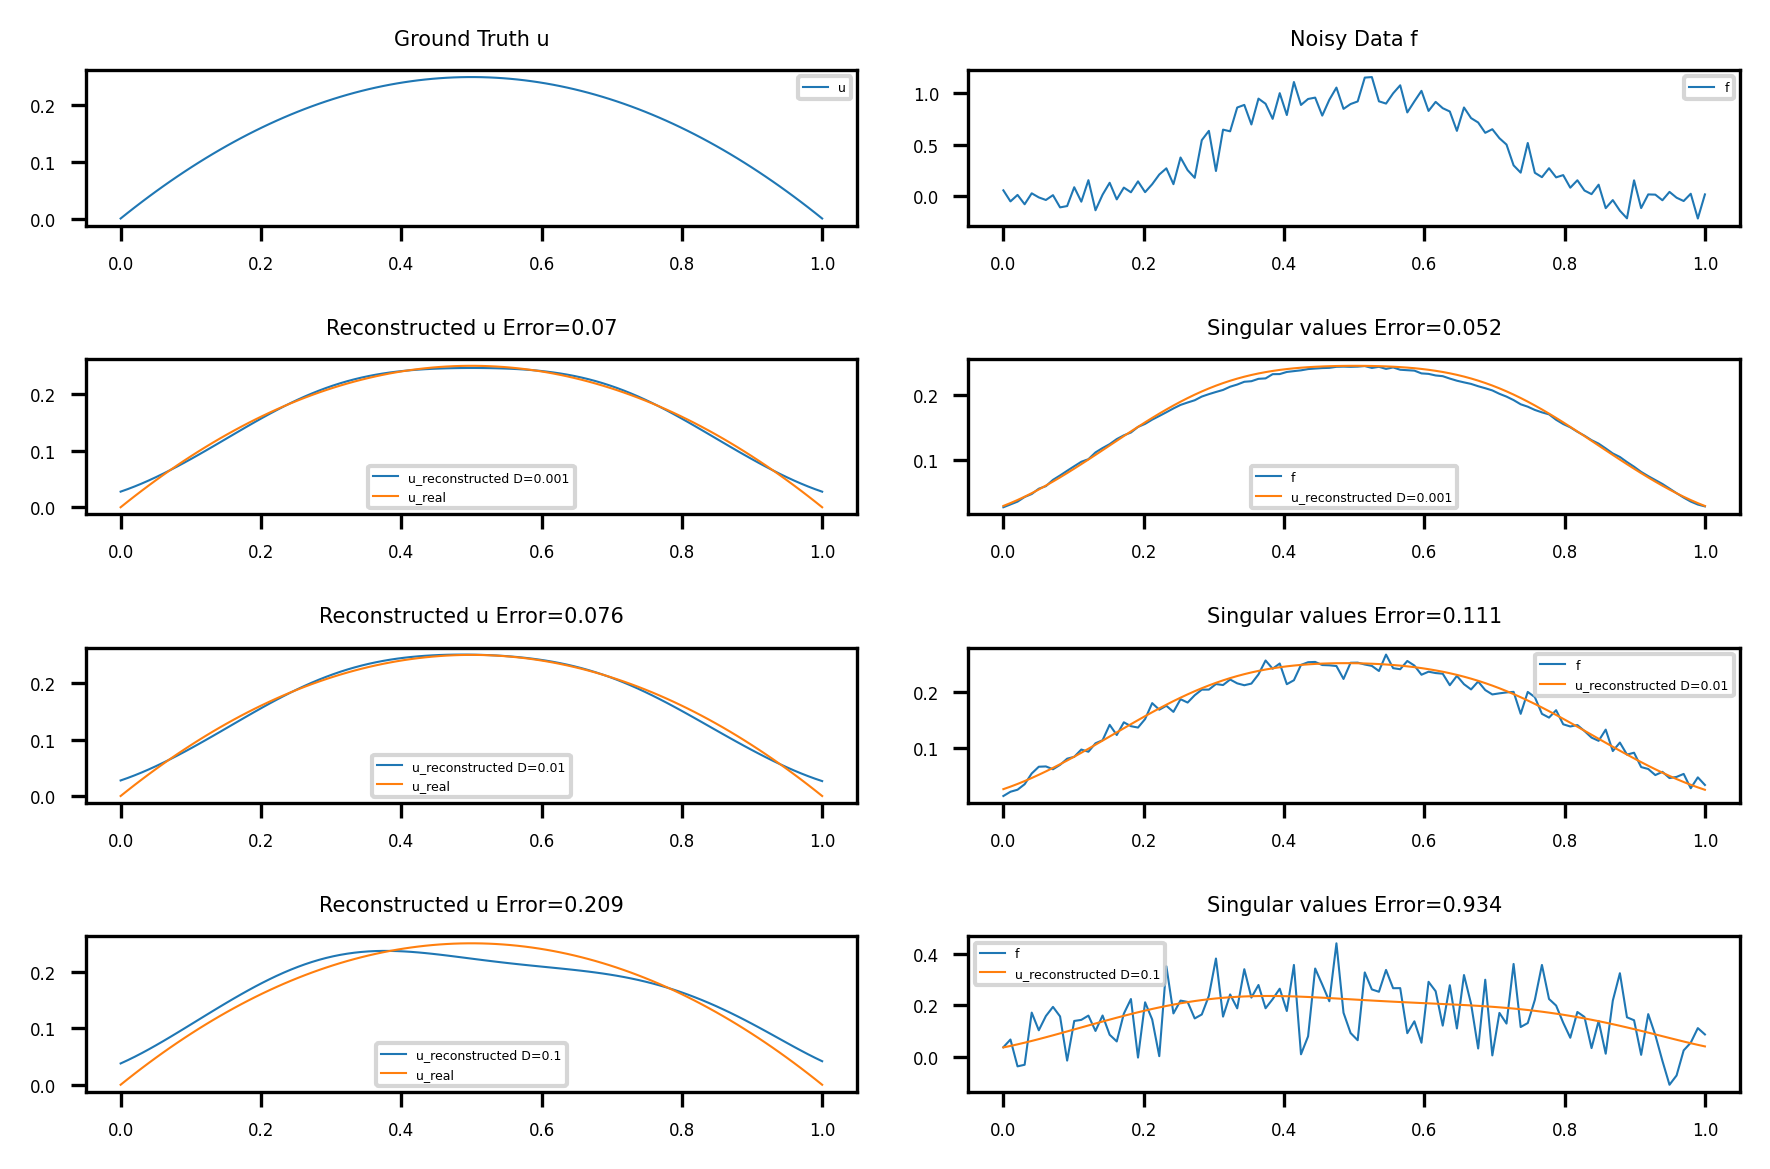

In [134]:

# # define the K_ for truncation
K_truncate_int = 5 # the rest would be truncated

# plot
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(6,4))

axes[0,0].plot(x,u2,label='u', linewidth=0.5)
axes[0,0].set_title('Ground Truth u', fontsize=5)
axes[0,0].legend(fontsize=3)
axes[0, 0].tick_params(labelsize=4)

axes[0,1].plot(x,f,label='f', linewidth=0.5)
axes[0,1].set_title('Noisy Data f', fontsize=5)
axes[0,1].legend(fontsize=3)
axes[0, 1].tick_params(labelsize=4)

# loop over different noise levels
for i, delta in enumerate(deltas):
    f_cur = K@u2 + delta*np.random.randn(n)

    # compute truncated SVD and reconstructed signal
    U, s, Vt = np.linalg.svd(K)
    U_, s_, Vt_ = la.svd(K)
    # Make sure the SVD works well
    assert np.allclose(U, U_)
    assert np.allclose(s, s_)
    assert np.allclose(Vt, Vt_)

    #Truncate
    s_truncate = np.zeros_like(s)
    s_truncate[:K_truncate_int] = s[:K_truncate_int]
    #Making the matrix inversible by small num
    Addstable = np.diag(s_truncate[:K_truncate_int])*0.1

    #Truncate sigma
    Sigma_k_inv = np.diag(1/s_truncate[:K_truncate_int])# + Addstable
    #Truncate U and V
    U_k = U[:, :K_truncate_int]
    Vt_k = Vt[:K_truncate_int, :]

    # Compute K
    K_truncate = U_k @ np.diag(s_truncate[:K_truncate_int]) @ Vt_k
    K_pinv_truncate = Vt_k.T @ Sigma_k_inv @ U_k.T @ f_cur
    
    # plot reconstructed signal
    u_reconstructed = K_pinv_truncate

    # Compute error
    Berror = round(np.linalg.norm(u2 - u_reconstructed, ord=2),3)
    ferror = round(np.linalg.norm(f_cur - u_reconstructed, ord=2),3)

    axes[i+1,0].plot(x,u_reconstructed,label=f'u_reconstructed D={delta}',linewidth=0.5)
    axes[i+1,0].plot(x,u2,label='u_real',linewidth=0.5)
    axes[i+1,0].set_title(f'Reconstructed u Error={Berror}', fontsize=5)
    axes[i+1, 0].tick_params(labelsize=4)
    axes[i+1,0].legend(fontsize=3)
    
    # plot singular values
    axes[i+1,1].plot(x,f_cur,label='f',linewidth=0.5)
    axes[i+1,1].plot(x,u_reconstructed,label=f'u_reconstructed D={delta}',linewidth=0.5)
    axes[i+1,1].tick_params(labelsize=4)
    axes[i+1,1].set_title(f'Singular values Error={ferror}', fontsize=5)
    axes[i+1,1].legend(fontsize=3)
    
fig.tight_layout()
plt.show()


Based on the graph, we can observe two important things. Firstly, in all cases, when comparing the backward and forward errors, the backward error is consistently smaller. This observation indicates that we are inversing to the original signal `u` and not to the noisy one. Thus, the backward operator is more accurate in inverting the signal than the forward operator.

Secondly, we also notice that increasing the noise variance results in both the backward and forward errors performing worse. This observation suggests that higher noise levels negatively impact the inversion accuracy regardless of the operator used.

# Lets observe the two differen tetrucnated singular matrix

After evaluating the forward and backward errors, we will compare the backward operators for `trucated_K` and K_truncate=13 to observe the differences in their respective errors.

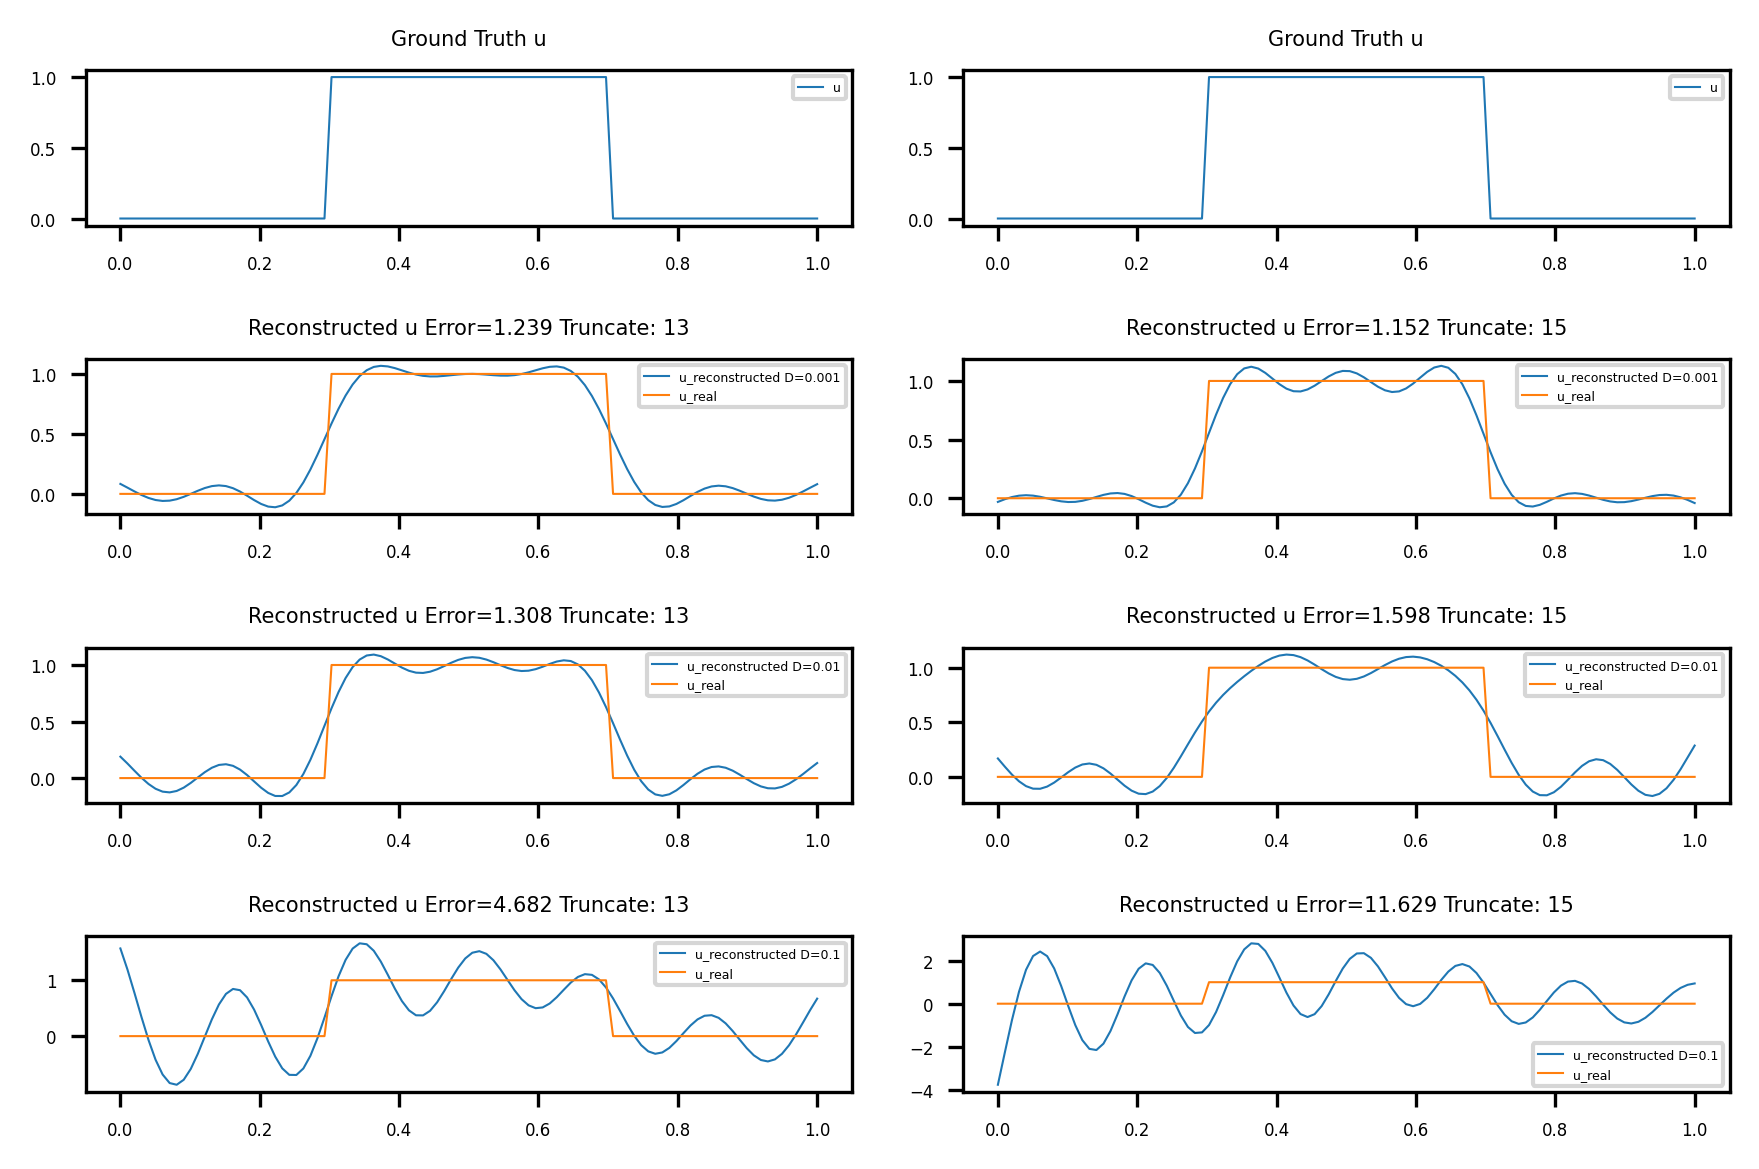

In [135]:
# define the K_ for truncation
K_Trunc = [13, 15]

# plot
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(6,4))

axes[0,0].plot(x,u1,label='u', linewidth=0.5)
axes[0,0].set_title('Ground Truth u', fontsize=5)
axes[0,0].legend(fontsize=3)
axes[0, 0].tick_params(labelsize=4)

axes[0,1].plot(x,u1,label='u', linewidth=0.5)
axes[0,1].set_title('Ground Truth u', fontsize=5)
axes[0,1].legend(fontsize=3)
axes[0, 1].tick_params(labelsize=4)


for T_idx in range(len(K_Trunc)):
    # loop over different noise levels
    K_truncate_int = K_Trunc[T_idx]
    for i, delta in enumerate(deltas):
        f_cur = K@u1 + delta*np.random.randn(n)

        # compute truncated SVD and reconstructed signal
        U, s, Vt = np.linalg.svd(K)
        U_, s_, Vt_ = la.svd(K)
        # Make sure the SVD works well
        assert np.allclose(U, U_)
        assert np.allclose(s, s_)
        assert np.allclose(Vt, Vt_)

        #Truncate
        s_truncate = np.zeros_like(s)
        s_truncate[:K_truncate_int] = s[:K_truncate_int]
        #Making the matrix inversible by small num
        Addstable = np.diag(s_truncate[:K_truncate_int])*0.1

        #Truncate sigma
        Sigma_k_inv = np.diag(1/s_truncate[:K_truncate_int]) #+ Addstable
        #Truncate U and V
        U_k = U[:, :K_truncate_int]
        Vt_k = Vt[:K_truncate_int, :]

        # Compute K
        K_truncate = U_k @ np.diag(s_truncate[:K_truncate_int]) @ Vt_k
        K_pinv_truncate = Vt_k.T @ Sigma_k_inv @ U_k.T @ f_cur
        
        # plot reconstructed signal
        u_reconstructed = K_pinv_truncate

        # Compute error
        Berror = round(np.linalg.norm(u1 - u_reconstructed, ord=2),3)
        ferror = round(np.linalg.norm(f_cur - u_reconstructed, ord=2),3)

        axes[i+1,T_idx].plot(x,u_reconstructed,label=f'u_reconstructed D={delta}', linewidth=0.5)
        axes[i+1,T_idx].plot(x,u1,label='u_real', linewidth=0.5)
        axes[i+1,T_idx].set_title(f'Reconstructed u Error={Berror} Truncate: {K_Trunc[T_idx]}', fontsize=5)
        axes[i+1, T_idx].tick_params(labelsize=4)
        axes[i+1,T_idx].legend(fontsize=3)
        
    
fig.tight_layout()
plt.show()



In [136]:
min_error = np.inf
best_K = None
K_Trunc_l =list(np.arange(30))
print(f"Checked Truncation k {K_Trunc_l}")
deltas_Backward_error ={}
for T_idx in range(len(K_Trunc_l)):
    # loop over different noise levels
    K_truncate_int = K_Trunc_l[T_idx]
    for i, delta in enumerate(deltas):
        f_cur = K@u1 + delta*np.random.randn(n)

        # compute truncated SVD and reconstructed signal
        U, s, Vt = np.linalg.svd(K)
        U_, s_, Vt_ = la.svd(K)
        # Make sure the SVD works well
        assert np.allclose(U, U_)
        assert np.allclose(s, s_)
        assert np.allclose(Vt, Vt_)

        #Truncate
        s_truncate = np.zeros_like(s)
        s_truncate[:K_truncate_int] = s[:K_truncate_int]
        #Making the matrix inversible by small num
        Addstable = np.diag(s_truncate[:K_truncate_int])*0.1

        #Truncate sigma
        Sigma_k_inv = np.diag(1/s_truncate[:K_truncate_int]) #+ Addstable
        #Truncate U and V
        U_k = U[:, :K_truncate_int]
        Vt_k = Vt[:K_truncate_int, :]

        # Compute K
        K_truncate = U_k @ np.diag(s_truncate[:K_truncate_int]) @ Vt_k
        K_pinv_truncate = Vt_k.T @ Sigma_k_inv @ U_k.T @ f_cur
        
        # plot reconstructed signal
        u_reconstructed = K_pinv_truncate

        # Compute error
        Berror = round(np.linalg.norm(u1 - u_reconstructed, ord=2),3)
        ferror = round(np.linalg.norm(f_cur - u_reconstructed, ord=2),3)

        # update best_K if error is smaller
        if Berror < min_error:
            min_error = Berror
            best_K = K_truncate_int
    deltas_Backward_error[str(K_truncate_int)] = best_K

print(deltas_Backward_error)
# best_K now contains the K that minimizes the B_error
print(f"best_K: {best_K}")



Checked Truncation k [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
{'0': 0, '1': 1, '2': 1, '3': 3, '4': 3, '5': 5, '6': 5, '7': 7, '8': 7, '9': 9, '10': 9, '11': 11, '12': 11, '13': 13, '14': 13, '15': 15, '16': 15, '17': 15, '18': 15, '19': 15, '20': 15, '21': 15, '22': 15, '23': 15, '24': 15, '25': 15, '26': 15, '27': 15, '28': 15, '29': 15}
best_K: 15


It should be noted that since the noise added to the signal is randomized in each loop, the optimal truncation value that minimizes the error changes in each iteration. However, for the u1 heavyside signal, the optimal truncation value typically falls within the range of 13-18.

## Heavysite 2
We would do the same process, first, we would plot both `K=5,13`

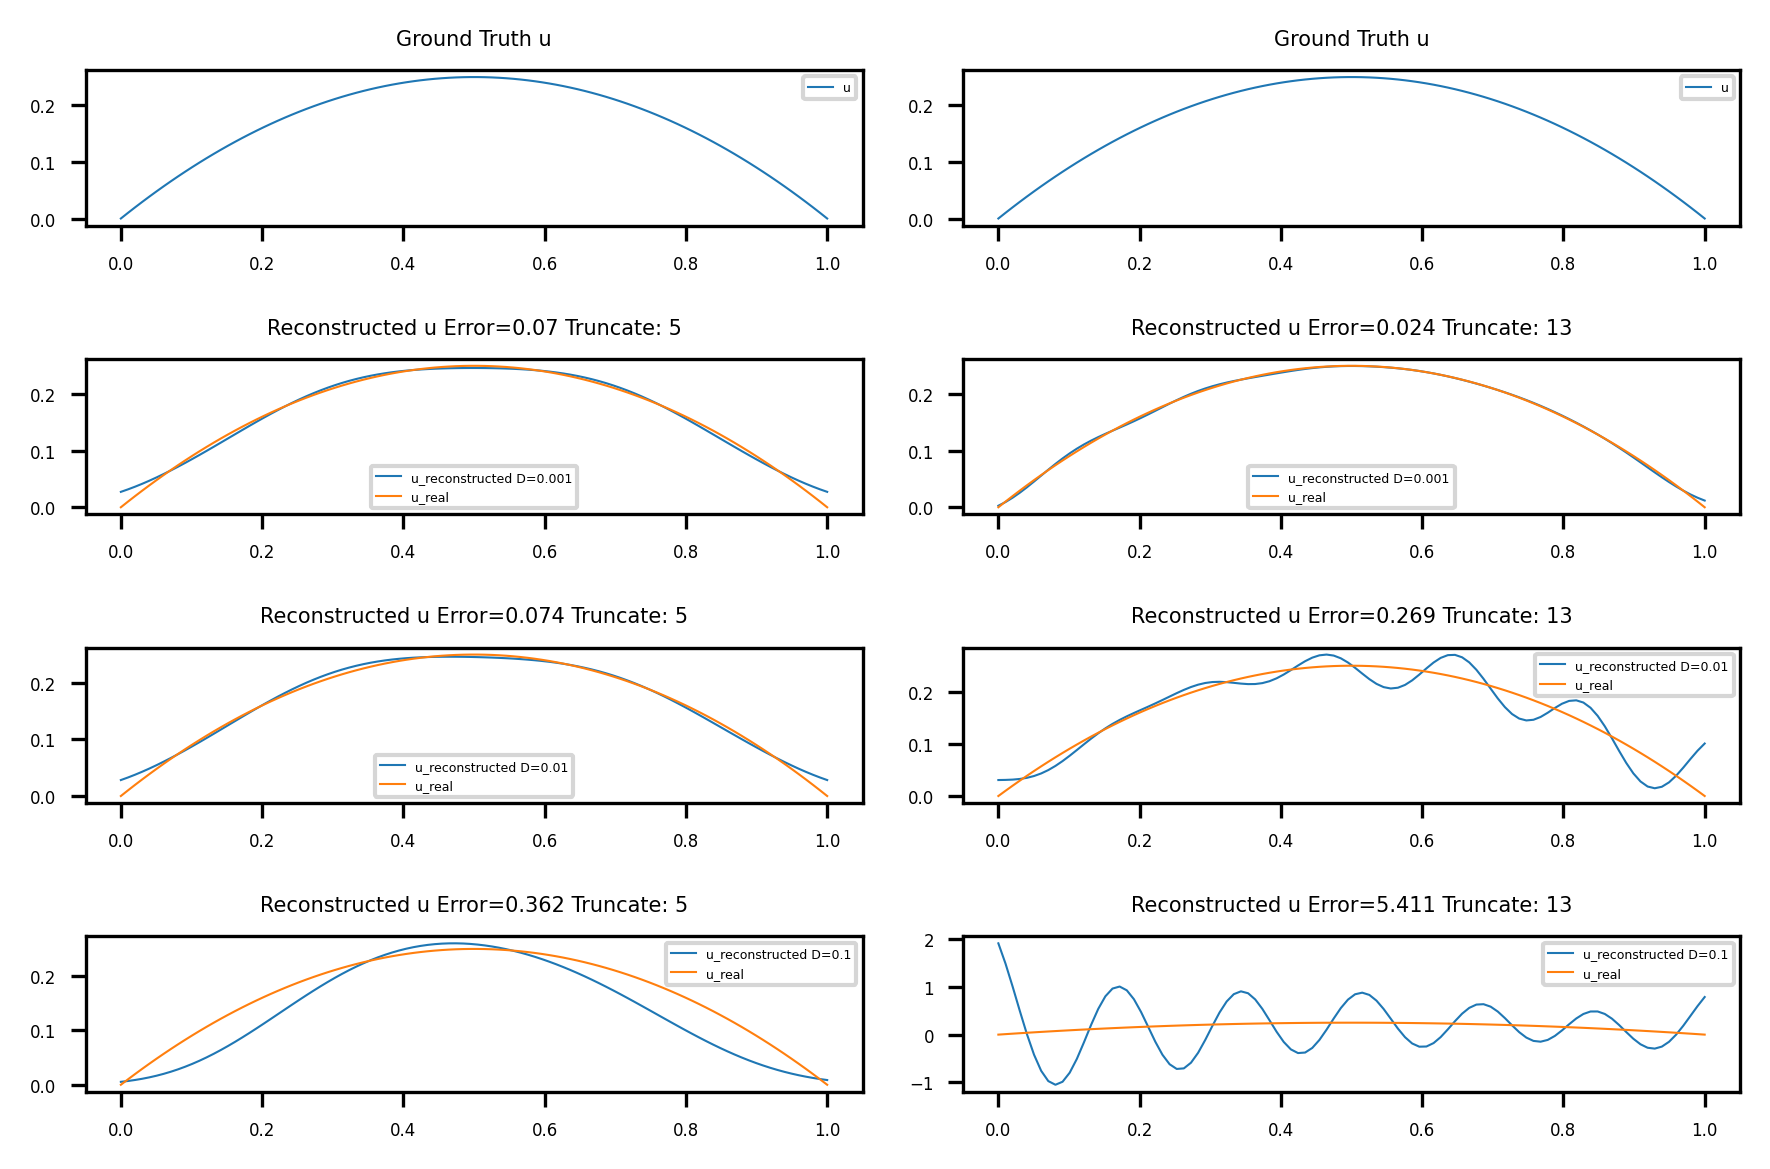

In [137]:
# define the K_ for truncation
K_Trunc = [5, 13]

# plot
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(6,4))

axes[0,0].plot(x,u2,label='u', linewidth=0.5)
axes[0,0].set_title('Ground Truth u', fontsize=5)
axes[0,0].legend(fontsize=3)
axes[0, 0].tick_params(labelsize=4)

axes[0,1].plot(x,u2,label='u', linewidth=0.5)
axes[0,1].set_title('Ground Truth u', fontsize=5)
axes[0,1].legend(fontsize=3)
axes[0, 1].tick_params(labelsize=4)


for T_idx in range(len(K_Trunc)):
    # loop over different noise levels
    K_truncate_int = K_Trunc[T_idx]
    for i, delta in enumerate(deltas):
        f_cur = K@u2 + delta*np.random.randn(n)

        # compute truncated SVD and reconstructed signal
        U, s, Vt = np.linalg.svd(K)
        U_, s_, Vt_ = la.svd(K)
        # Make sure the SVD works well
        assert np.allclose(U, U_)
        assert np.allclose(s, s_)
        assert np.allclose(Vt, Vt_)

        #Truncate
        s_truncate = np.zeros_like(s)
        s_truncate[:K_truncate_int] = s[:K_truncate_int]
        #Making the matrix inversible by small num
        Addstable = np.diag(s_truncate[:K_truncate_int])*0.1

        #Truncate sigma
        Sigma_k_inv = np.diag(1/s_truncate[:K_truncate_int]) #+ Addstable
        #Truncate U and V
        U_k = U[:, :K_truncate_int]
        Vt_k = Vt[:K_truncate_int, :]

        # Compute K
        K_truncate = U_k @ np.diag(s_truncate[:K_truncate_int]) @ Vt_k
        K_pinv_truncate = Vt_k.T @ Sigma_k_inv @ U_k.T @ f_cur
        
        # plot reconstructed signal
        u_reconstructed = K_pinv_truncate

        # Compute error
        Berror = round(np.linalg.norm(u2 - u_reconstructed, ord=2),3)
        ferror = round(np.linalg.norm(f_cur - u_reconstructed, ord=2),3)

        axes[i+1,T_idx].plot(x,u_reconstructed,label=f'u_reconstructed D={delta}', linewidth=0.5)
        axes[i+1,T_idx].plot(x,u2,label='u_real', linewidth=0.5)
        axes[i+1,T_idx].set_title(f'Reconstructed u Error={Berror} Truncate: {K_Trunc[T_idx]}', fontsize=5)
        axes[i+1, T_idx].tick_params(labelsize=4)
        axes[i+1,T_idx].legend(fontsize=3)
        
    
fig.tight_layout()
plt.show()



In [138]:
min_error = np.inf
best_K = None
K_Trunc_l =list(np.arange(30))
print(f"Checked Truncation k {K_Trunc_l}")
deltas_Backward_error ={}
for T_idx in range(len(K_Trunc_l)):
    # loop over different noise levels
    K_truncate_int = K_Trunc_l[T_idx]
    for i, delta in enumerate(deltas):
        f_cur = K@u2 + delta*np.random.randn(n)

        # compute truncated SVD and reconstructed signal
        U, s, Vt = np.linalg.svd(K)
        U_, s_, Vt_ = la.svd(K)
        # Make sure the SVD works well
        assert np.allclose(U, U_)
        assert np.allclose(s, s_)
        assert np.allclose(Vt, Vt_)

        #Truncate
        s_truncate = np.zeros_like(s)
        s_truncate[:K_truncate_int] = s[:K_truncate_int]
        #Making the matrix inversible by small num
        Addstable = np.diag(s_truncate[:K_truncate_int])*0.1

        #Truncate sigma
        Sigma_k_inv = np.diag(1/s_truncate[:K_truncate_int]) #+ Addstable
        #Truncate U and V
        U_k = U[:, :K_truncate_int]
        Vt_k = Vt[:K_truncate_int, :]

        # Compute K
        K_truncate = U_k @ np.diag(s_truncate[:K_truncate_int]) @ Vt_k
        K_pinv_truncate = Vt_k.T @ Sigma_k_inv @ U_k.T @ f_cur
        
        # plot reconstructed signal
        u_reconstructed = K_pinv_truncate

        # Compute error
        Berror = round(np.linalg.norm(u2 - u_reconstructed, ord=2),3)
        ferror = round(np.linalg.norm(f_cur - u_reconstructed, ord=2),3)

        # update best_K if error is smaller
        if Berror < min_error:
            min_error = Berror
            best_K = K_truncate_int
    deltas_Backward_error[str(K_truncate_int)] = best_K

print(deltas_Backward_error)
# best_K now contains the K that minimizes the B_error
print(f"best_K: {best_K}")



Checked Truncation k [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
{'0': 0, '1': 1, '2': 1, '3': 3, '4': 3, '5': 5, '6': 5, '7': 7, '8': 7, '9': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 13, '15': 13, '16': 13, '17': 13, '18': 13, '19': 13, '20': 13, '21': 13, '22': 13, '23': 13, '24': 13, '25': 13, '26': 13, '27': 13, '28': 13, '29': 13}
best_K: 13


Based on the graph, we can observe that as the `K_truncate` value increases, the reconstruction becomes more unstable. This observation is expected since we know that the problem is ill-posed. Increasing the truncation value results in a loss of information in the inversion process, which makes the reconstruction more susceptible to numerical errors and instability. Therefore, it is crucial to find the appropriate truncation value that balances reconstruction accuracy and stability.

When I compute more than only the two `[5, 13]` in order to find the best truncation, it is obseved, that the best based on the backward error, apperas to be when `K_truncate =13`, yet when looping over a larger range, it appers to be `K_truncate=12`.

## Question D

To gather additional knowledge, we shall investigate the SVD decomposition in greater detail. Truncation can be advantageous in some circumstances, as we have already seen, so we will look into the Discrete Picard Condition to offer a more thorough analysis. The key question is whether the Fourier coefficients in the denominator decay more quickly than those in the numerator. Avoiding division by a very tiny number is essential since doing so could make the issue unstable and a small change in the data could result in a disproportionately significant change in the solution.



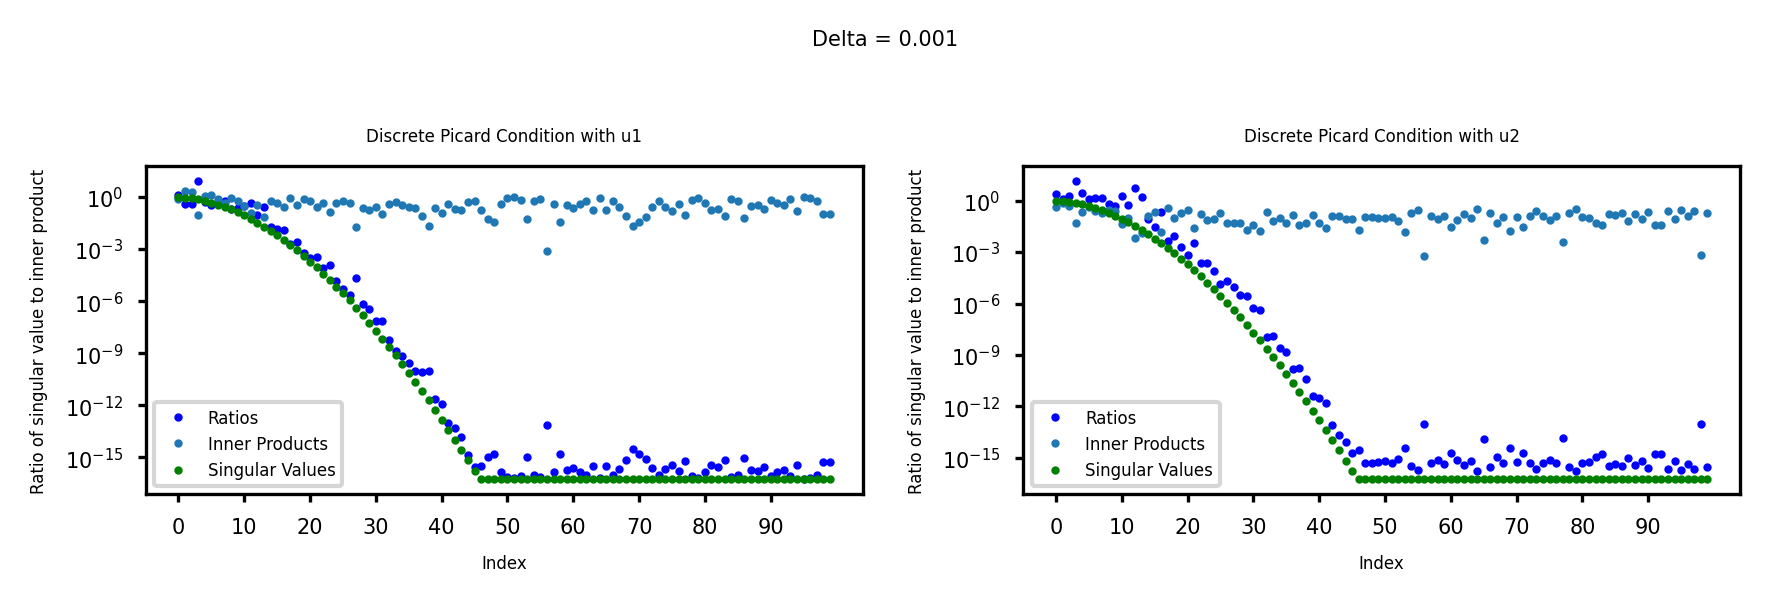

In [139]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,2))

for i, u in enumerate([u1, u2]):
    f_cur = K@u + deltas[0]*np.random.randn(n)
    U, s, Vt = np.linalg.svd(K)
    # Compute inner products between left singular vectors and data vector f
    inner_prods = abs(U @ f_cur)
    # Compute ratio of singular values to inner products
    ratios = s / inner_prods

    # Plot ratios on a semilogarithmic scale
    axes[i].semilogy(ratios, 'bo', markersize=1, label='Ratios')
    axes[i].semilogy(inner_prods, 'o', markersize=1, label='Inner Products')
    axes[i].semilogy(s, 'go', markersize=1, label='Singular Values')

    axes[i].set_title(f'Discrete Picard Condition with u{i+1}', fontsize=4)
    axes[i].set_xlabel('Index', fontsize=4)
    axes[i].set_ylabel('Ratio of singular value to inner product', fontsize=4)
    axes[i].legend(prop={'size': 4})
    axes[i].set_xticks(np.arange(0, len(s), 10))
    axes[i].tick_params(axis='both', which='major', labelsize=5, length=2)


fig.suptitle(f'Delta = {deltas[0]}', fontsize=5) # set global title
plt.tight_layout()
plt.show()


As can be observed in the graph, the decay of singular values in the case of u1 is much faster compared to the case of u2. This means that the decay of the singular values for u1 is steeper, indicating that the first few singular values dominate the solution. On the other hand, the decay of the singular values for u2 is slower, indicating that a larger number of singular values contribute to the solution.